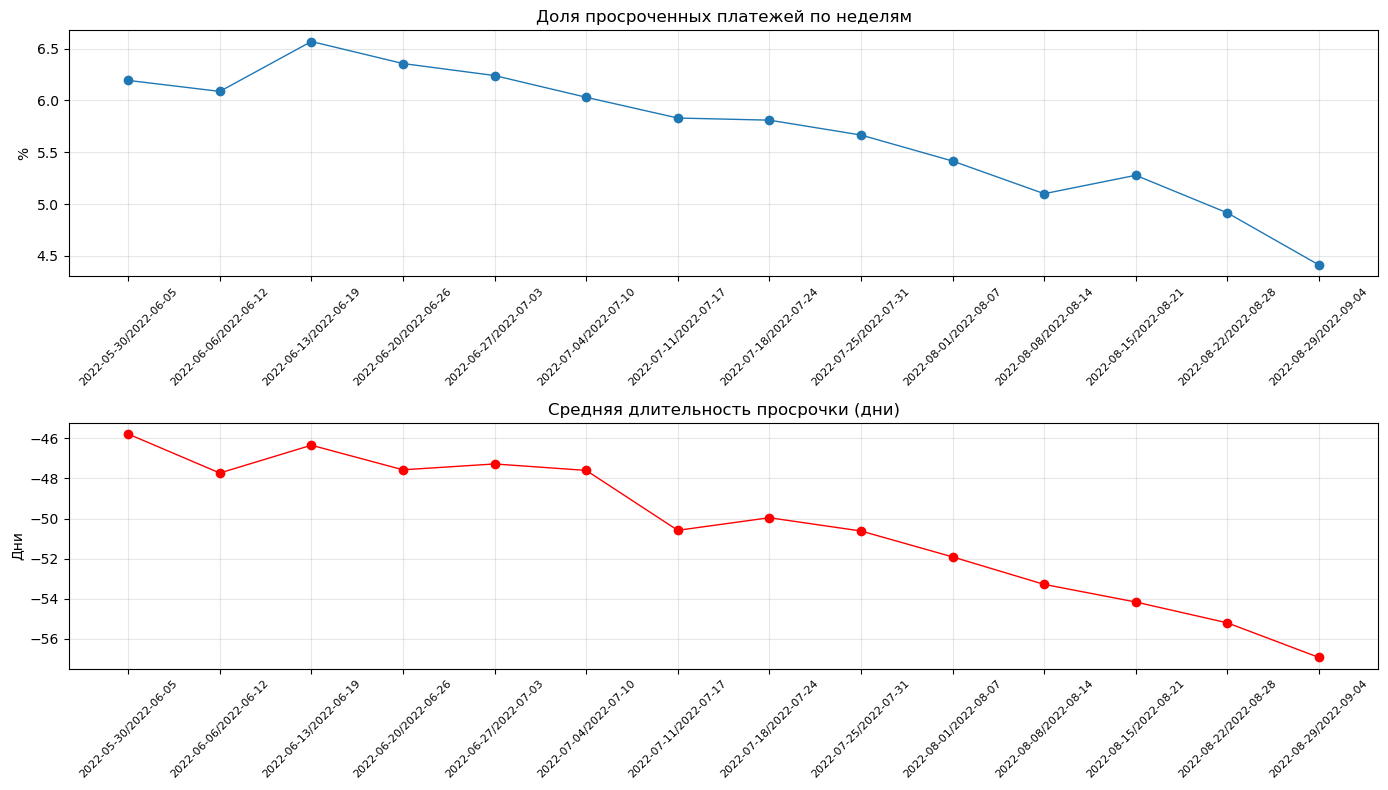

Тренд доли просрочек: ↓ 13.55% в неделю
Тренд длительности просрочки: ↓ 0.81 дней в неделю

Пиковая неделя по просрочкам: 2022-06-13/2022-06-19


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

# Загрузка данных
orders_df = pd.read_csv('orders.csv')
payments_df = pd.read_csv('payments.csv')
plan_df = pd.read_csv('plan.csv')

# Преобразование дат
def fix_dates(df):
    for col in df.columns:
        if '_at' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')
    return df

orders_df = fix_dates(orders_df)
payments_df = fix_dates(payments_df)
plan_df = fix_dates(plan_df)

# Приведем order_id к строковому типу в обеих таблицах
payments_df['order_id'] = payments_df['order_id'].astype(str)
plan_df['order_id'] = plan_df['order_id'].astype(str)

# Объединение
merged_payments = pd.merge(
    plan_df,
    payments_df,
    on='order_id',
    how='left', 
    suffixes=('_plan', '_paid')
)

# Расчет показателей
merged_payments['delay_days'] = (merged_payments['paid_at'] - merged_payments['plan_at']).dt.days
merged_payments['is_delayed'] = merged_payments['delay_days'] > 0
merged_payments['shortage'] = merged_payments['plan_sum_total'] - merged_payments['paid_sum']

# Приведение order_id к строковому типу
merged_payments['order_id'] = merged_payments['order_id'].astype(str)
orders_df['order_id'] = orders_df['order_id'].astype(str)

# Удаление пропусков
merged_payments = merged_payments.dropna(subset=['order_id'])
orders_df = orders_df.dropna(subset=['order_id'])

# Группируем на неделям
orders_df['created_week'] = orders_df['created_at'].dt.to_period('W')

# Объединяем с данными о неделе создания заявки
merged_data = pd.merge(
    merged_payments,
    orders_df[['order_id', 'created_week']],
    on='order_id',
    how='left'
)

# Агрегация по неделям
delay_stats = merged_data.groupby('created_week').agg(
    total_orders=('order_id', 'nunique'),
    delayed_payments=('is_delayed', 'sum'),
    avg_delay_days=('delay_days', 'mean'),
    total_shortage=('shortage', 'sum')
).reset_index()

# Визуализация
plt.figure(figsize=(14, 8))

# График доли просроченных платежей
plt.subplot(2, 1, 1)
plt.plot(delay_stats['created_week'].astype(str), 
         delay_stats['delayed_payments'] / delay_stats['total_orders'], 
         marker='o', linestyle='-', linewidth=1)
plt.title('Доля просроченных платежей по неделям', fontsize=12)
plt.ylabel('%', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.grid(alpha=0.3)

# График средней просрочки
plt.subplot(2, 1, 2)
plt.plot(delay_stats['created_week'].astype(str), 
         delay_stats['avg_delay_days'], 
         marker='o', color='red', linestyle='-', linewidth=1)
plt.title('Средняя длительность просрочки (дни)', fontsize=12)
plt.ylabel('Дни', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ тренда с линейной регрессией
delay_stats['week_num'] = range(len(delay_stats))

X = delay_stats[['week_num']]
y_delay = delay_stats['delayed_payments'] / delay_stats['total_orders']
y_days = delay_stats['avg_delay_days']

# Для доли просрочек
model_delay = LinearRegression()
model_delay.fit(X, y_delay)
trend_delay = model_delay.coef_[0]

# Для длительности просрочки
model_days = LinearRegression()
model_days.fit(X, y_days)
trend_days = model_days.coef_[0]

print(f"Тренд доли просрочек: {'↑' if trend_delay > 0 else '↓'} {abs(trend_delay):.2%} в неделю")
print(f"Тренд длительности просрочки: {'↑' if trend_days > 0 else '↓'} {abs(trend_days):.2f} дней в неделю")

# Дополнительный анализ пиковых недель
max_delay_week = delay_stats.loc[delay_stats['delayed_payments'].idxmax(), 'created_week']
print(f"\nПиковая неделя по просрочкам: {max_delay_week}")